In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pickle

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from yellowbrick.model_selection import feature_importances

#===============================================================================================#

# Classification Models Class

#===============================================================================================#

class Classification():
    
    """
    This class is for performing classifcation algorithms such as Logistic Regression, Decision Tree, Random Forest, and SVM.
    
    Parameters
    ----------
    model_type: 'Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM'
    the type of classifcation algorithm you would like to apply 
    
    x_train: dataframe
    the independant variables of the training data
    
    x_val: dataframe
    the independant variables of the validation data
    
    y_train: series
    the target variable of the training data
    
    y_val: series
    the target variable of the validation data
    
    """
    
    def __init__(self,model_type,x_train,x_val,y_train,y_val):

        self.model_type = model_type
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val
        self.scores_table = pd.DataFrame()
        self.feature_importances = pd.DataFrame()
        self.name = self
        
        if self.model_type == 'Logistic Regression':
            self.technique = LogisticRegression(fit_intercept=False)
        elif self.model_type == 'Decision Tree':
            self.technique = DecisionTreeClassifier(random_state=42)
        elif self.model_type == 'Random Forest':
            self.technique = RandomForestClassifier(n_estimators=20,n_jobs=-1,random_state=42)
        elif self.model_type == 'SVM':
            self.technique = SVC()
        elif self.model_type == 'Naive Bayes':
            self.technique = GaussianNB()
        elif self.model_type == 'KNN':
            self.technique = KNeighborsClassifier(n_jobs=-1)
            
#===============================================================================================#

# Score Function

#===============================================================================================#

    def scores(self,model,x_train,x_val,y_train,y_val):
        
        """
        Gets the accuracy for the given data and creates a dataframe containing scores.
        Parameters
        ----------
        model: 'Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM'
        the type of classifcation applied
        x_train: dataframe
        the independant variables of the training data
        x_val: dataframe
        the independant variables of the validation data
        y_train: series
        the target variable of the training data
        y_val: series
        the target variable of the validation data
        
        Returns
        ----------
        scores_table: a dataframe with the model used, the train accuracy and validation accuracy
        """
        
        self.acc_train = self.best_model.score(x_train,y_train)
        self.acc_val = self.best_model.score(x_val,y_val)
        
        d = {'Model Name': [self.model_type],
             'Train Accuracy': [self.acc_train], 
             'Validation Accuracy': [self.acc_val],
             'Accuracy Difference':[self.acc_train-self.acc_val]}
        self.scores_table = pd.DataFrame(data=d)
        
        return self.scores_table


#===============================================================================================#

# Get Scores Function

#===============================================================================================#

    def get_scores(self,params,cv_type):
        
        """
        Performs a gridsearch cross validation with given hyperparameters and data.
        Gets the accuracy for the given data and creates a dataframe containing scores.
        Parameters
        ----------
        param_grid: dictionary 
        specified hyperparameters for chosen classification algorithm to be passed through gridsearch cross validation
        
        cv_type: 'skf'
        the type of cross validation split to be used for gridsearch
        """
        
        classifier = self.technique
        fit_classifier = classifier.fit(self.x_train,self.y_train)
        opt_model = GridSearchCV(fit_classifier,
                                 params,
                                 cv=cv_type,
                                 scoring='accuracy',
                                 return_train_score=True,
                                 n_jobs=-1)
        self.opt_model = opt_model.fit(self.x_train,self.y_train) 
        self.best_model = opt_model.best_estimator_
        self.scores = Classification.scores(self,self.best_model,self.x_train,self.x_val,self.y_train,self.y_val)
        self.best_params = opt_model.best_params_
        display(self.scores_table)
        if params == {}:
            pass
        else:
            print("The best hyperparameters are: ", self.best_params,'\n')
        self.y_validated = self.best_model.predict(self.x_val)
        self.classification_report = pd.DataFrame.from_dict(classification_report(self.y_val,self.y_validated,output_dict=True)).iloc[0:3,0:5]
        return self.classification_report

#===============================================================================================#

# Feature Importance Function

#===============================================================================================#
   
    def get_feature_importances(self):
        
        """
        Create a confusion matrix.
        Returns
        ----------
        feature_importances_bar : a bar chart with feature importance of given model
        """
        if (self.model_type == 'Decision Tree') or (self.model_type == 'Random Forest') or (self.model_type == 'SVM'):    
            self.feature_importances_table = pd.DataFrame(self.best_model.feature_importances_,
                                                    index = self.x_train.columns,
                                                    columns=['Importance']).sort_values('Importance',ascending =False)
            plt.figure(figsize=(9,7.5))
            self.feature_importances_bar = sns.barplot(y= self.feature_importances_table.index[:15], x= self.feature_importances_table['Importance'][:15])
            plt.show()
            return self.feature_importances_bar
        
        else:
            return print('This classification method does not have the attribute feature importance.')

#===============================================================================================#

# Confusion Matrix Function

#===============================================================================================#

    def conf_matrix(self):
        
        """
        Create a confusion matrix.
        
        Returns
        ----------
        scores_table: a confusion matrix
        """
        
        plt.figure(figsize=(9,9))
        ax = sns.heatmap(confusion_matrix(self.y_val, self.y_validated),
                         annot= True, 
                         fmt = '.4g', 
                         cbar=0,
                         xticklabels=[1,2,3,4,5],
                         yticklabels=[1,2,3,4,5])
        ax.set(xlabel='Predicted', ylabel='True')
        plt.show()



#===============================================================================================#

# Test Score Function

#===============================================================================================#

    def get_test_scores(self,X_test,y_test):
        
        """
        Gets a ROC AUC score for given data and creates a dataframe containing scores.
        Creates a ROC plot.
        
        Parameters
        ----------
        x_test: dataframe 
        independant variables of the test data
        
        y_test: dataframe 
        target variable of the test data
        """
            
        self.y_test = y_test
        self.x_test = X_test
        self.scores_table = pd.DataFrame()
        self.test_scores = Classification.scores(self,self.best_model,self.x_train,self.x_test,self.y_train,self.y_test)
        display(self.scores_table)
        self.y_tested = self.best_model.predict(self.x_test)
        self.test_classification_report = pd.DataFrame.from_dict(classification_report(self.y_test,self.y_tested,output_dict=True)).iloc[0:3,0:5]
        
        return self.test_classification_report
    
#===============================================================================================#

# Show Test Confusion Matrix Function

#===============================================================================================#

    def test_conf_matrix(self):
        
        """
        Create a confusion matrix for the test data.
        
        Returns
        ----------
        scores_table: a confusion matrix
        """
        plt.figure(figsize=(9,9))
        ax = sns.heatmap(confusion_matrix(self.y_test, self.y_tested),
                         annot= True, 
                         fmt = '.4g', 
                         cbar=0,
                         xticklabels=[1,2,3,4,5],
                         yticklabels=[1,2,3,4,5])
        ax.set(xlabel='Predicted', ylabel='True')
        plt.show()

In [9]:
import pandas as pd
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, StackingClassifier
from xgboost.sklearn import XGBClassifier

#===============================================================================================#

# Ensemble Models Class

#===============================================================================================#

class Ensemble(Classification):
    
    """
    This class is for performing ensemble algorithms such as voting, adaboost, xgboost, or stacking.
    
    Parameters
    ----------
    ensemble_method: 'Voting', 'AdaBoost', 'XGBoost', 'Stacking'
    the type of ensemble algorithm you would like to apply
    
    estimators: list
    the classifcation models to be used by the ensemble algorithm
    
    x_train: dataframe
    the independant variables of the training data
    
    x_val: dataframe
    the independant variables of the validation data
    
    y_train: series
    the target variable of the training data
    
    y_val: series
    the target variable of the validation data
    
    """
    
    def __init__(self, ensemble_method, estimators, X_train, X_val, y_train, y_val):
        
        self.ensemble_method = ensemble_method
        self.x_train = X_train
        self.y_train = y_train
        self.x_val = X_val
        self.y_val = y_val
        self.model_type = ensemble_method
        self.scores_table = pd.DataFrame()
        
        if self.ensemble_method == "Voting":
            self.technique = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)
        elif self.ensemble_method == "AdaBoost":
            self.technique = AdaBoostClassifier(estimators, algorithm='SAMME')
        elif self.ensemble_method == "XGBoost":
            self.technique = XGBClassifier(n_jobs=-1)
        elif self.ensemble_method == "Stacking":
            self.technique = StackingClassifier(estimators)

In [10]:
sns.set_context('poster')

In [11]:
x_train = pd.read_csv('/Users/morganmccorkle/Documents/Springboard/Capstones/Capstone2New/tripadvisor/x_train_data.csv')
y_train = pd.read_csv('/Users/morganmccorkle/Documents/Springboard/Capstones/Capstone2New/tripadvisor/y_train_data.csv')
x_test = pd.read_csv('/Users/morganmccorkle/Documents/Springboard/Capstones/Capstone2New/tripadvisor/x_test_data.csv')
y_test = pd.read_csv('/Users/morganmccorkle/Documents/Springboard/Capstones/Capstone2New/tripadvisor/y_test_data.csv')

df = pd.read_csv('/Users/morganmccorkle/Documents/Springboard/Capstones/Capstone2New/tripadvisor/all_models.csv')

In [12]:
df

,Unnamed: 0,Model Name,Train Accuracy,Validation Accuracy,Accuracy Difference
0,0,Decision Tree,0.526288,0.480219,0.046070
1,0,Random Forest,0.695905,0.526288,0.169617
2,0,Logistic Regression,0.597258,0.568454,0.028804
3,0,SVM,0.590838,0.567413,0.023425
4,0,Naive Bayes,0.512320,0.487246,0.025074
5,0,KNN,0.515096,0.508069,0.007028
6,0,AdaBoost,0.527590,0.516137,0.011452
7,0,XGBoost,0.853028,0.542426,0.310602


In [21]:
best_model_log_reg = pickle.load(open('/Users/morganmccorkle/Documents/Springboard/Capstones/Capstone2New/tripadvisor/Models/Logistic Regression.pkl','rb'))

In [22]:
best_model_log_reg.get_test_scores(x_test,y_test)

,Model Name,Train Accuracy,Validation Accuracy,Accuracy Difference
0,Logistic Regression,0.597258,0.563147,0.034112


,1,2,3,4,5
precision,0.574394,0.338509,0.344697,0.486561,0.648194
recall,0.456044,0.252900,0.168207,0.450830,0.816299
f1-score,0.508423,0.289509,0.226087,0.468015,0.722599


In [23]:
best_model_log_reg.classification_report

,1,2,3,4,5
precision,0.545455,0.404255,0.381720,0.464801,0.662621
recall,0.487633,0.269886,0.165888,0.472911,0.807692
f1-score,0.514925,0.323680,0.231270,0.468821,0.728000


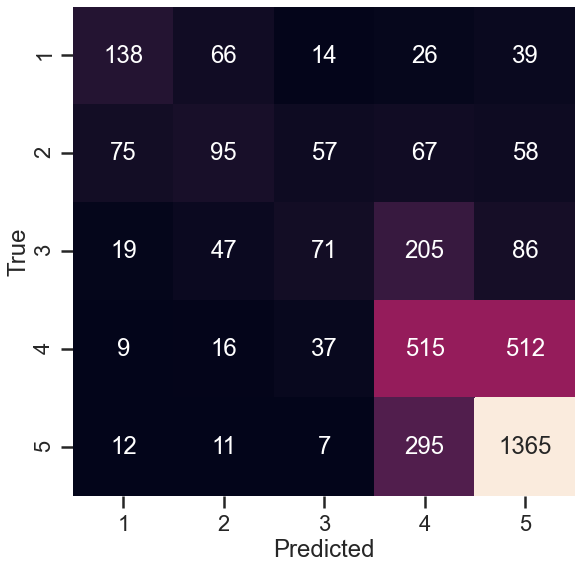

In [19]:
best_model_log_reg.conf_matrix()

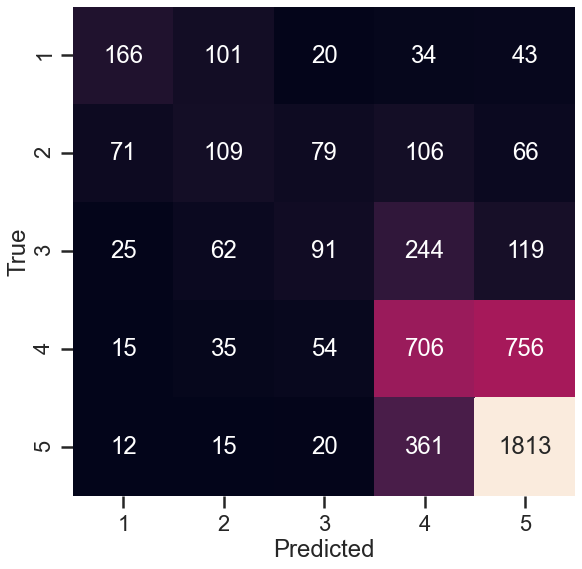

In [24]:
best_model_log_reg.test_conf_matrix()

In [26]:
best_model_dec_tree = best_model_log_reg = pickle.load(open('/Users/morganmccorkle/Documents/Springboard/Capstones/Capstone2New/tripadvisor/Models/Decision Tree.pkl','rb'))

In [27]:
best_model_dec_tree.get_test_scores(x_test,y_test)

,Model Name,Train Accuracy,Validation Accuracy,Accuracy Difference
0,Decision Tree,0.526288,0.469647,0.056642


,1,2,3,4,5
precision,0.445455,0.223529,0.314607,0.385400,0.527245
recall,0.269231,0.132251,0.051756,0.313538,0.779829
f1-score,0.335616,0.166181,0.088889,0.345775,0.629132


In [28]:
best_model_dec_tree.classification_report

,1,2,3,4,5
precision,0.440000,0.281081,0.257576,0.378408,0.543079
recall,0.349823,0.147727,0.039720,0.318641,0.786982
f1-score,0.389764,0.193669,0.068826,0.345962,0.642667


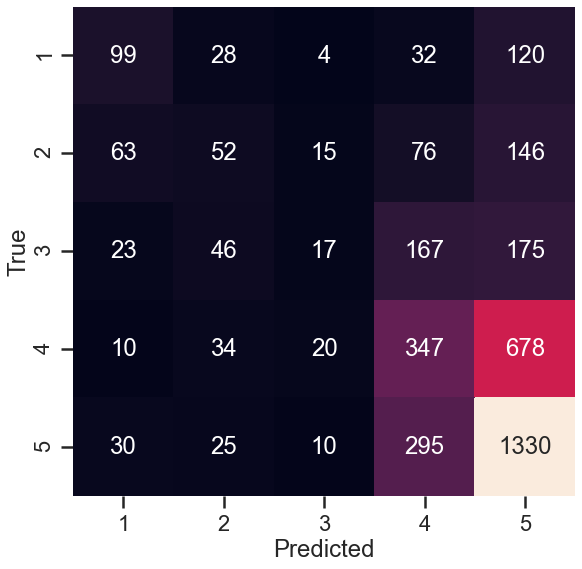

In [29]:
best_model_dec_tree.conf_matrix()

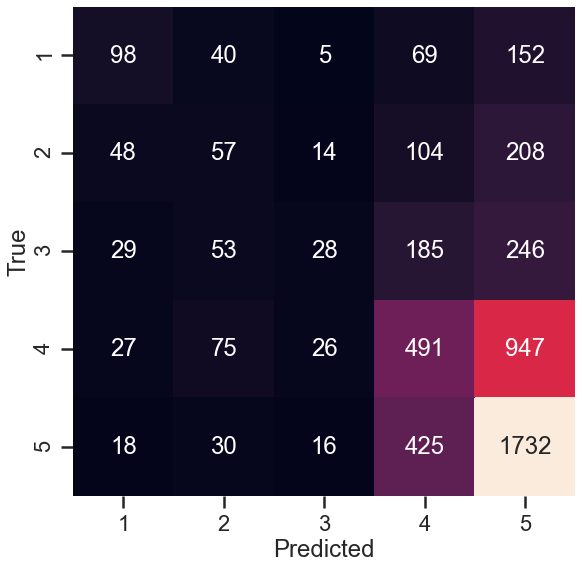

In [30]:
best_model_dec_tree.test_conf_matrix()

In [31]:
best_model_rand_forest = pickle.load(open('/Users/morganmccorkle/Documents/Springboard/Capstones/Capstone2New/tripadvisor/Models/Random Forest.pkl','rb'))

In [32]:
best_model_rand_forest.get_test_scores(x_test,y_test)

,Model Name,Train Accuracy,Validation Accuracy,Accuracy Difference
0,Random Forest,0.695905,0.512981,0.182924


,1,2,3,4,5
precision,0.639344,0.291139,0.344828,0.407065,0.550628
recall,0.321429,0.053364,0.055453,0.309068,0.888789
f1-score,0.427788,0.090196,0.095541,0.351361,0.679986


In [33]:
best_model_rand_forest.classification_report

,1,2,3,4,5
precision,0.578378,0.465753,0.417910,0.410317,0.564189
recall,0.378092,0.096591,0.065421,0.321396,0.889349
f1-score,0.457265,0.160000,0.113131,0.360453,0.690400


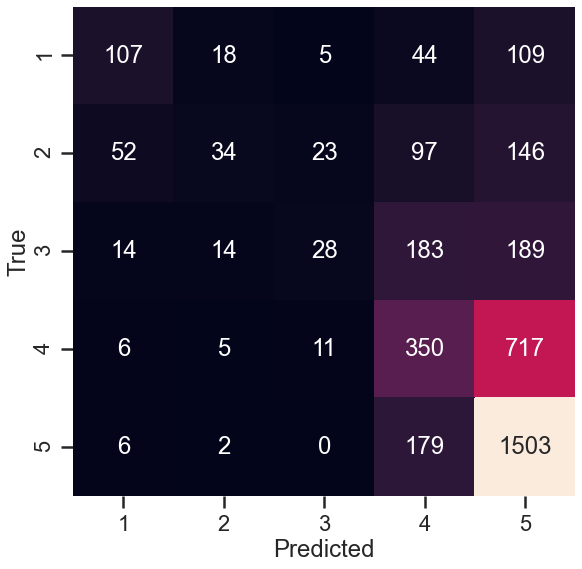

In [34]:
best_model_rand_forest.conf_matrix()

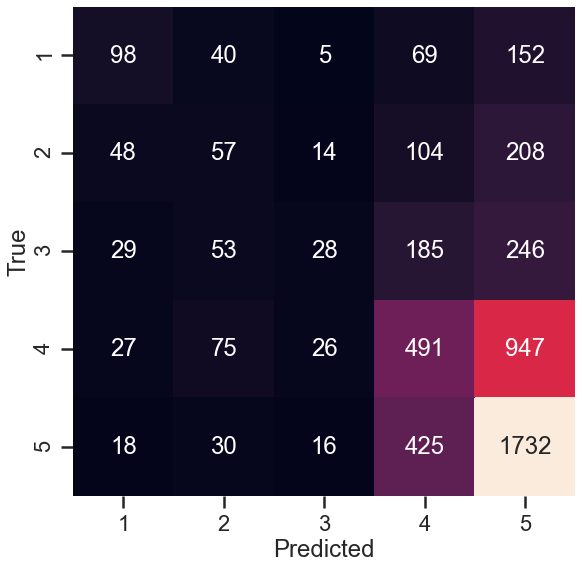

In [35]:
best_model_dec_tree.test_conf_matrix()

In [39]:
best_model_svm = pickle.load(open('/Users/morganmccorkle/Documents/Springboard/Capstones/Capstone2New/tripadvisor/Models/SVM.pkl','rb'))
best_model_log_reg = pickle.load(open('/Users/morganmccorkle/Documents/Springboard/Capstones/Capstone2New/tripadvisor/Models/Logistic Regression.pkl','rb'))
best_model_naive_bayes = pickle.load(open('/Users/morganmccorkle/Documents/Springboard/Capstones/Capstone2New/tripadvisor/Models/Naive Bayes.pkl','rb'))
best_model_knn = pickle.load(open('/Users/morganmccorkle/Documents/Springboard/Capstones/Capstone2New/tripadvisor/Models/KNN.pkl','rb'))
best_model_adaboost = pickle.load(open('/Users/morganmccorkle/Documents/Springboard/Capstones/Capstone2New/tripadvisor/Models/AdaBoost.pkl','rb'))
best_model_xgboost = pickle.load(open('/Users/morganmccorkle/Documents/Springboard/Capstones/Capstone2New/tripadvisor/Models/XGBoost.pkl','rb'))

In [40]:
best_model_svm.get_test_scores(x_test,y_test)

,Model Name,Train Accuracy,Validation Accuracy,Accuracy Difference
0,SVM,0.590838,0.557486,0.033352


,1,2,3,4,5
precision,0.620553,0.369501,0.436170,0.456393,0.630928
recall,0.431319,0.292343,0.075786,0.444444,0.826655
f1-score,0.508914,0.326425,0.129134,0.450340,0.715650


In [41]:
best_model_svm.classification_report

,1,2,3,4,5
precision,0.578475,0.410448,0.430556,0.456597,0.650682
recall,0.455830,0.312500,0.072430,0.483012,0.818935
f1-score,0.509881,0.354839,0.124000,0.469433,0.725177


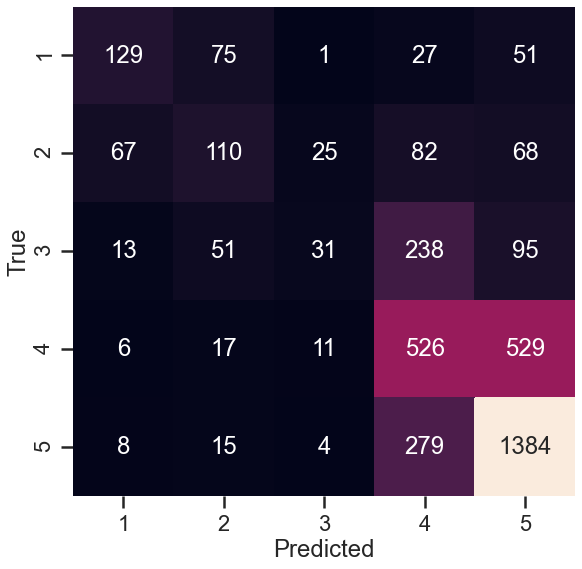

In [42]:
best_model_svm.conf_matrix()

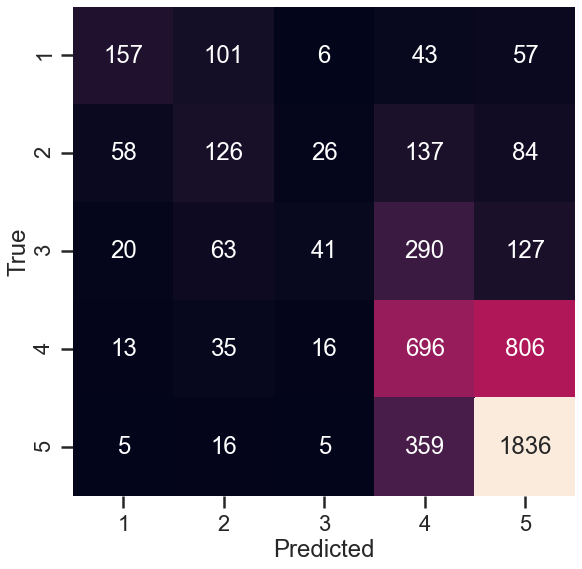

In [47]:
best_model_svm.test_conf_matrix()

In [44]:
best_model_naive_bayes.get_test_scores(x_test,y_test)

,Model Name,Train Accuracy,Validation Accuracy,Accuracy Difference
0,Naive Bayes,0.51232,0.484677,0.027643


,1,2,3,4,5
precision,0.331646,0.209213,0.252174,0.471591,0.717989
recall,0.719780,0.252900,0.321627,0.371009,0.610986
f1-score,0.454073,0.228992,0.282697,0.415297,0.660180


In [45]:
best_model_naive_bayes.classification_report

,1,2,3,4,5
precision,0.334432,0.213296,0.287698,0.450051,0.721944
recall,0.717314,0.218750,0.338785,0.401286,0.597633
f1-score,0.456180,0.215989,0.311159,0.424272,0.653933


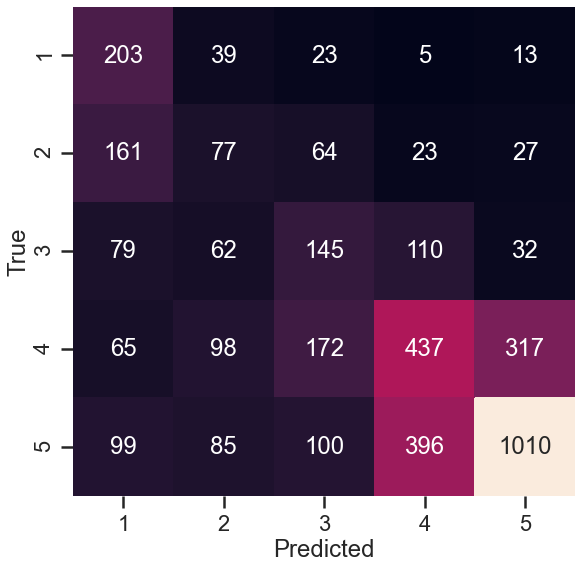

In [46]:
best_model_naive_bayes.conf_matrix()

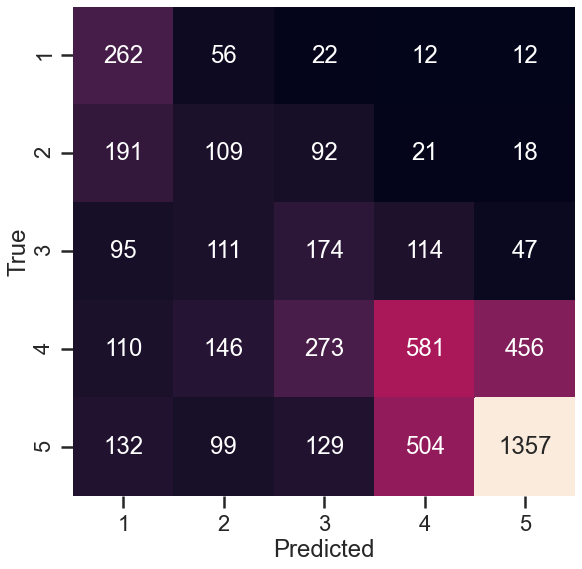

In [48]:
best_model_naive_bayes.test_conf_matrix()

In [49]:
best_model_knn.get_test_scores(x_test,y_test)

,Model Name,Train Accuracy,Validation Accuracy,Accuracy Difference
0,KNN,0.515096,0.501074,0.014023


,1,2,3,4,5
precision,0.657143,0.333333,0.466667,0.382716,0.536605
recall,0.126374,0.009281,0.012939,0.296935,0.920756
f1-score,0.211982,0.018059,0.025180,0.334412,0.678050


In [50]:
best_model_knn.classification_report

,1,2,3,4,5
precision,0.600000,0.250000,0.533333,0.385584,0.543964
recall,0.159011,0.008523,0.018692,0.309458,0.922485
f1-score,0.251397,0.016484,0.036117,0.343352,0.684372


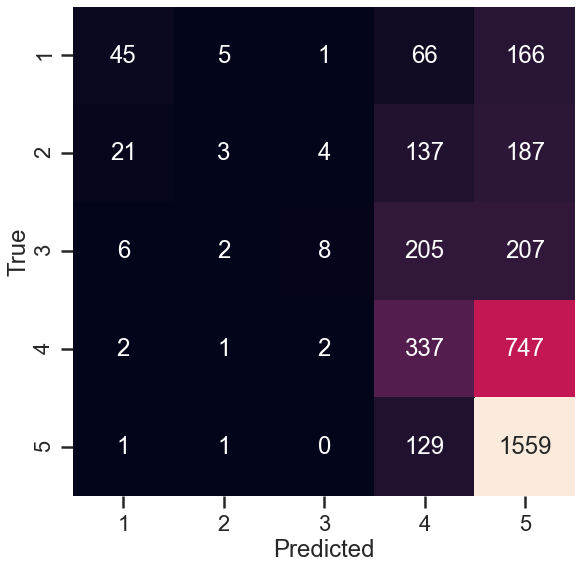

In [52]:
best_model_knn.conf_matrix()

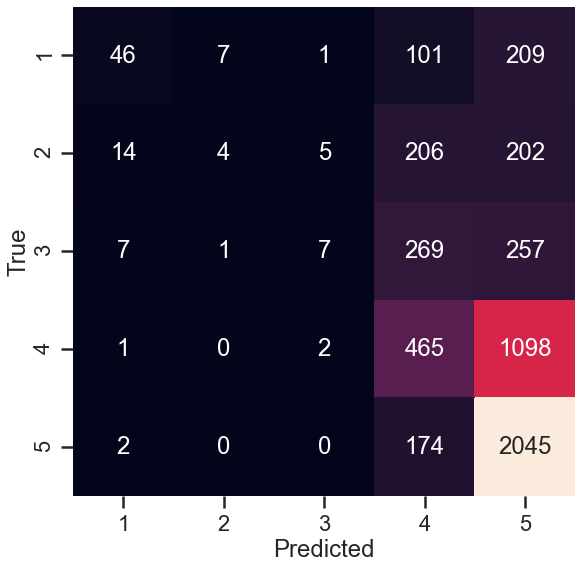

In [53]:
best_model_knn.test_conf_matrix()

In [54]:
best_model_adaboost.get_test_scores(x_test,y_test)

,Model Name,Train Accuracy,Validation Accuracy,Accuracy Difference
0,AdaBoost,0.52759,0.507125,0.020465


,1,2,3,4,5
precision,0.524638,0.321149,0.281905,0.414634,0.636961
recall,0.497253,0.285383,0.273567,0.379949,0.698334
f1-score,0.510578,0.302211,0.277674,0.396534,0.666237


In [55]:
best_model_adaboost.classification_report

,1,2,3,4,5
precision,0.493421,0.331010,0.307125,0.407656,0.659811
recall,0.530035,0.269886,0.292056,0.391185,0.702367
f1-score,0.511073,0.297340,0.299401,0.399250,0.680424


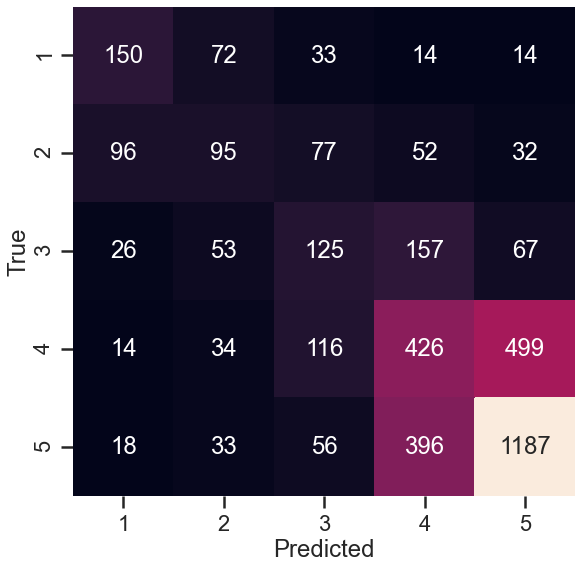

In [56]:
best_model_adaboost.conf_matrix()

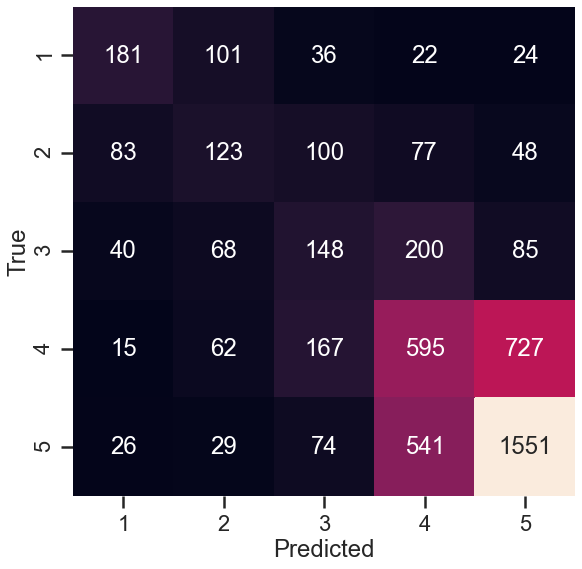

In [57]:
best_model_adaboost.test_conf_matrix()

In [58]:
best_model_xgboost.get_test_scores(x_test,y_test)

,Model Name,Train Accuracy,Validation Accuracy,Accuracy Difference
0,XGBoost,0.853028,0.545188,0.30784


,1,2,3,4,5
precision,0.578231,0.342857,0.322884,0.463571,0.630769
recall,0.467033,0.250580,0.190388,0.414432,0.793787
f1-score,0.516717,0.289544,0.239535,0.437626,0.702951


In [59]:
best_model_xgboost.classification_report

,1,2,3,4,5
precision,0.513986,0.407725,0.356223,0.426276,0.643701
recall,0.519435,0.269886,0.193925,0.414141,0.773964
f1-score,0.516696,0.324786,0.251135,0.420121,0.702848


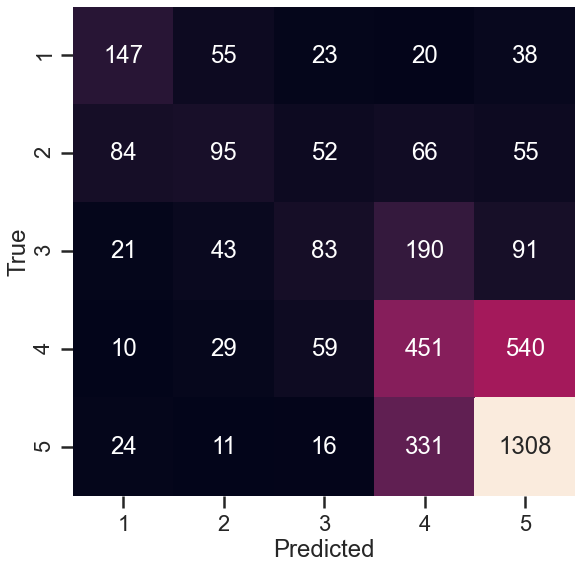

In [60]:
best_model_xgboost.conf_matrix()

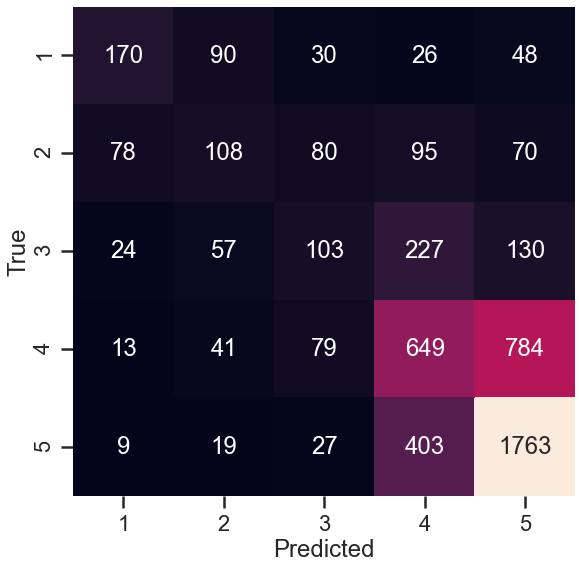

In [61]:
best_model_xgboost.test_conf_matrix()

In [62]:
best_model_dec_tree.get_test_scores(x_test,y_test)

,Model Name,Train Accuracy,Validation Accuracy,Accuracy Difference
0,Decision Tree,0.526288,0.469647,0.056642


,1,2,3,4,5
precision,0.445455,0.223529,0.314607,0.385400,0.527245
recall,0.269231,0.132251,0.051756,0.313538,0.779829
f1-score,0.335616,0.166181,0.088889,0.345775,0.629132


In [63]:
best_model_rand_forest.get_test_scores(x_test,y_test)

,Model Name,Train Accuracy,Validation Accuracy,Accuracy Difference
0,Random Forest,0.695905,0.512981,0.182924


,1,2,3,4,5
precision,0.639344,0.291139,0.344828,0.407065,0.550628
recall,0.321429,0.053364,0.055453,0.309068,0.888789
f1-score,0.427788,0.090196,0.095541,0.351361,0.679986


In [64]:
best_model_log_reg.get_test_scores(x_test,y_test)

,Model Name,Train Accuracy,Validation Accuracy,Accuracy Difference
0,Logistic Regression,0.597258,0.563147,0.034112


,1,2,3,4,5
precision,0.574394,0.338509,0.344697,0.486561,0.648194
recall,0.456044,0.252900,0.168207,0.450830,0.816299
f1-score,0.508423,0.289509,0.226087,0.468015,0.722599


In [65]:
best_model_svm.get_test_scores(x_test,y_test)

,Model Name,Train Accuracy,Validation Accuracy,Accuracy Difference
0,SVM,0.590838,0.557486,0.033352


,1,2,3,4,5
precision,0.620553,0.369501,0.436170,0.456393,0.630928
recall,0.431319,0.292343,0.075786,0.444444,0.826655
f1-score,0.508914,0.326425,0.129134,0.450340,0.715650


In [66]:
best_model_naive_bayes.get_test_scores(x_test,y_test)

,Model Name,Train Accuracy,Validation Accuracy,Accuracy Difference
0,Naive Bayes,0.51232,0.484677,0.027643


,1,2,3,4,5
precision,0.331646,0.209213,0.252174,0.471591,0.717989
recall,0.719780,0.252900,0.321627,0.371009,0.610986
f1-score,0.454073,0.228992,0.282697,0.415297,0.660180


In [67]:
best_model_knn.get_test_scores(x_test,y_test)

,Model Name,Train Accuracy,Validation Accuracy,Accuracy Difference
0,KNN,0.515096,0.501074,0.014023


,1,2,3,4,5
precision,0.657143,0.333333,0.466667,0.382716,0.536605
recall,0.126374,0.009281,0.012939,0.296935,0.920756
f1-score,0.211982,0.018059,0.025180,0.334412,0.678050


In [68]:
best_model_adaboost.get_test_scores(x_test,y_test)

,Model Name,Train Accuracy,Validation Accuracy,Accuracy Difference
0,AdaBoost,0.52759,0.507125,0.020465


,1,2,3,4,5
precision,0.524638,0.321149,0.281905,0.414634,0.636961
recall,0.497253,0.285383,0.273567,0.379949,0.698334
f1-score,0.510578,0.302211,0.277674,0.396534,0.666237


In [69]:
best_model_xgboost.get_test_scores(x_test,y_test)

,Model Name,Train Accuracy,Validation Accuracy,Accuracy Difference
0,XGBoost,0.853028,0.545188,0.30784


,1,2,3,4,5
precision,0.578231,0.342857,0.322884,0.463571,0.630769
recall,0.467033,0.250580,0.190388,0.414432,0.793787
f1-score,0.516717,0.289544,0.239535,0.437626,0.702951


# the best model is logistic regression since it has high train and validation accuracies and a low accuracy difference